# Velocity and pumping diagnostics after PharaGlow analysis (for videos with lawns)

## Changing names (user input required)

#### Strain directories

In [1]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/GRU101/RFP_24h/10x/"
INF100 = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_batch/INF100/"
INF102 = "/media/scholz_la/soma/Nicolina/INF102/RFP_24h/10x/10x_INF102_analyzed/"
INF103 = "/media/scholz_la/soma/Nicolina/INF103/RFP_24h/10x/10x_INF103_analyzed/"
INF5 = "/media/scholz_la/soma/Nicolina/INF5/RFP_24h/10x/10x_INF5_analyzed/"
INF4 = "/media/scholz_la/soma/Nicolina/INF4/10x_INF4_analyzed/"
INF101 = '/media/scholz_la/soma/Nicolina/INF101/RFP_24h/10x/10x_INF101_analyzed/'
cfresh = '/media/scholz_la/soma/Nicolina/GRU101/RFP_fresh/10x/10x_GRU101_freshlawn_analyzed/'
c5h = '/media/soma/Nicolina/GRU101/RFP_5h/10x/10X_GRU101_5hrlawn_analyzed/'

# FINAL FIGURE NAME AND DIRECTORY (figure name MUST have .pdf at the end) - if not changed then the previous figure
# WILL be erased so be careful!
avgplot = "/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/10x_{}_diagnostics_average.pdf"
singleplot = "/home/nzjacic/Desktop/Diagnostics/Figures/Analysis_2/10x_{}_diagnostics_single.pdf"

#### Dictionary linking strain names to their folders and graph colors

In [2]:
# ADD STRAIN NAMES
strains = ['Control_24hr_lawn', 'INF100', 'INF102', 'INF103', 'INF5', 'INF4', 'INF101', 'Control_fresh', 
           'Control_5hr_lawn']

# ADD DIRECTORY VARIABLE
directories = [ctrl, INF100, INF102, INF103, INF5, INF4, INF101, cfresh, c5h]

# ADD COLORS
# if a syntax error comes up it's probably because you forgot to add a comma after the previous strain name
colors = {
        'INF100':'red',
        'Control_24hr_lawn':'blue',
        'INF102' :'green',
        'INF103':'orange',
        'INF5':'purple',
        'INF4' : 'pink',
        'INF101' : 'y',
        'Control_fresh' : 'm',
        'Control_5hr_lawn': 'c'
    }

#### Variables

In [14]:
# FPS?
fps = 30

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# HOW LONG BEFORE AND AFTER ENTRY WORM ENTRY TO PLOT (IN FRAMES)
tBefore = 40*fps
tAfter = 10*fps

## Extracting velocity and pumping information

### Importing packages

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import extract, util
from pharaglow.util import smooth

### Defining functions and dictionaries

#### Defining functions to extract velocity, pumping and kymo

In [5]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, ws = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, ws, prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

#### Defining how Python reads in Pharaglow and lawn data

In [6]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(pumps, wsDetrend = 300 , wsOutlier = 300, wsDetrendLocal = 30, prs = np.linspace(0.5,0.95,50) ):
    return extract.bestMatchPeaks(pumps, wsDetrend = 300 , wsOutlier = 300, wsDetrendLocal = 30, prs = prs)

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

def readData(dataFolder, umPerPx, fps, j = 0, nmax = None):
    df = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        if nmax != None and len(df.keys())>nmax-1:
            break
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            # pumping related data
            kymo = getKymo(traj, 'Straightened')
            rawPump = [-np.max(np.std(sIm, axis =1), axis =0) for sIm in traj['Straightened']]
            traj['pump'] = rawPump
            prs =  np.linspace(0.15,1.00,50)
            p, pump, pks, roc, metric  = getPumps(traj['pump'].values, prs = prs)
            #plotPumpAnalysis(pump, pks, roc, prs, time = traj['frame'], metric=metric)
            pinterp = np.interp(traj['frame'], p[:-1]+traj['frame'].iloc[0], fps/np.diff(p))
            # get a binary trace where pumps are 1 and non-pumps are 0
            tmp = np.zeros(len(t))
            tmp[p] = 1
            
            df[j] = {'time': t.values,
                     'x': traj['x'].values,
                     'y': traj['y'].values,
                             'velocity':v,
                             'peaks': p.values,
                             'pumpTrace':pump,
                             'binaryPumps': tmp,
                             'pumpInterp': pinterp,
                             'inside': traj['inside'].values,
                             'insideF': traj['insideHeadIntensity'].values,
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo,
                             'fps': fps,
                             'scale':umPerPx
                            }
            j +=1
    return df

#### Defining entry time

In [7]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

def getEntryTime(data, method = 'binary', window = 30):
    if method =='binary':
        # get the first entry from binarized lawn data. data should be the 'inside' variable from pharaglow
        t0 = np.where(data ==1)[0]
    if method =='fluorescence':
        data = pd.Series(data)
        data -= data.mean()
        data /= data.std()
        t0 = np.where(data>0)[0]
    if len(t0)>0:
       # plt.axvline(t0[0])
        return t0[0]
    else:
        return np.nan

### Helper functions to generate aligned velocity and pumping data
def alignData(df, tBefore, tAfter):
    """df is a dictionary created in readData. We will find the point of lawn entry and align and crop data to
    tBefore, TAfter. tBefore, tAfter are in frames."""
    for idx in df.keys():
        # identify the inside point t0 or set a flag that it doesn't enter
        try:
            # t0 is in frames not seconds!
            # CAN SWAP BETWEEN BINARY AND FLUORESCENT DETECTION OF LAWN ENTRY HERE
            t0 = getEntryTime(df[idx]['insideF'], method = 'fluorescence')
            #t0 = getEntryTime(df[idx]['inside'], method = 'binary')
            print(t0, np.mean(df[idx]['inside']))
            if t0 > tBefore and len(df[idx]['inside']) > t0+tAfter:
                # update the data
                df[idx]['t0'] = t0
                df[idx]['enter'] = True
            else:
                df[idx]['t0'] = None
                df[idx]['enter'] = False
        except IndexError:
            df[idx]['t0'] = None
            df[idx]['enter'] = False
        # calculate cropped versions of the data for animals that entered the lawn
        if df[idx]['enter']:
            for dname in ['insideF', 'velocity', 'time', 'pumpTrace', 'binaryPumps', 'pumpInterp']:
                df[idx][dname+'Cut'] = df[idx][dname][df[idx]['t0']-tBefore: df[idx]['t0']+tAfter+1]
            # peaks and other info
            df[idx]['peaksCut'] = df[idx]['peaks'][(df[idx]['peaks'] > df[idx]['t0']-tBefore)&
                                    (df[idx]['peaks'] < df[idx]['t0']+tAfter+1)]
            #shift the cut peaks to the correct locations relative to cut window
            df[idx]['peaksCut'] =  df[idx]['peaksCut'] - df[idx]['t0']+tBefore
            df[idx]['timeEntry'] = np.arange(-tBefore, tAfter+1)
            df[idx]['tBefore'] = tBefore
            df[idx]['tAfter'] = tAfter
    return df

#### Defining average plotting function

In [8]:
def graphing(Data, condition, plotpath, method = 'single', save = 'Yes'):
    # setting up GridSpec
    f1 = plt.figure(figsize = (16,4))
    grid = mpl.gridspec.GridSpec(ncols=3, nrows = 1, hspace = 0.3)
    # creating subplots
    axa = f1.add_subplot(grid[0,0])
    axb = f1.add_subplot(grid[0,1])
    axc = f1.add_subplot(grid[0,2])
    # axes dictionary
    axes = {
        'xlabel':'Time(s)',
        'ylabelv':'Velocity (um/s)',
        'ylabelp':'Pumping rate (Hz)',
        'ylabelf' : 'Fluorescence'
    }
    # extracting necessary data
    t, v, pr, f = [], [], [], []
    for idx in Data.keys():
        if Data[idx]['enter']:
            print(Data[idx]['filename'])
            # pumping rate using rolling mean rate in a rolling 1 second window
            tAfter = Data[idx]['tAfter'] 
            #tmp = pd.Series(df[idx]['binaryPumpsCut']).rolling(fps).sum()
            tmp = Data[idx]['pumpInterpCut']
            t.append(Data[idx]['timeEntry']/Data[idx]['fps'])
            pr.append(tmp)
            v.append(Data[idx]['velocityCut'])
            f.append(Data[idx]['insideFCut']/np.max(Data[idx]['insideFCut']))
    print ('Plotting', condition+'...')
    if method == 'average':
        mv, sv = np.mean(np.array(v), axis =0), np.std(np.array(v), axis =0)
        time = np.mean(t, axis=0)
        axa.plot(time, mv, color = colors[condition], alpha = 0.7)
        axa.fill_between(time, mv-sv, mv+sv, 
                             color = 'gray', alpha = 0.3)
    if method == 'single':
        time = t
        axa.plot(time, v, color = colors[condition], alpha = 0.1)
    #axa.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axa.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axa.annotate('n = '+str(len(v)), (0.8, 0.8), xycoords='axes fraction')
    axa.set_ylabel(axes['ylabelv'])
    axa.set_xlabel(axes['xlabel'])
    axa.set_ylim(0,200)
    # pumping rate across all trajectories and all movies per strain
    if method == 'average':
        mp, sp = np.mean(np.array(pr), axis = 0), np.std(np.array(pr), axis =0)
        axb.plot(time, mp, color = colors[condition], alpha = 0.5)
        axb.fill_between(time, mp-sp, mp+sp, 
                 color = 'gray', alpha = 0.3)
        axb.plot(time, smooth(mp, 50), 'black', lw =2)
    if method == 'single':
        axb.plot(time, pr, color = colors[condition], alpha = 0.1)
    #axb.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axb.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axb.annotate('n = '+str(len(pr)), (0.8, 0.8), xycoords='axes fraction')
    axb.set_ylabel(axes['ylabelp'])
    axb.set_xlabel(axes['xlabel'])
    axb.set_ylim(0,6)
    # fluorescence sanity check
    if method == 'average':
        mf, sf = np.mean(np.array(f), axis =0), np.std(np.array(f), axis =0)
        axc.plot(time, mf, color = colors[condition], alpha = 0.7)
        axc.fill_between(time, mf-sf, mf+sf, 
                             color = 'gray', alpha = 0.3)
    if method == 'single':
        axc.plot(time, f, color = colors[condition], alpha = 0.1)
    #axa.axvline(x = Data[idx]['timeEntry']/Data[idx]['fps'], color = 'black', dashes = (5, 2))
    axc.axvspan( 0, tAfter/Data[idx]['fps'], color='k', alpha=0.3)
    # making it pretty
    axc.annotate('n = '+str(len(f)), (0.8, 0.8), xycoords='axes fraction')
    axc.set_ylabel(axes['ylabelf'])
    axc.set_xlabel(axes['xlabel'])
    axc.set_ylim(0,1)
    # setting axes titles
    if method == 'average':
        axa.set_title('Average Velocity of Trajectories per Video')
        axb.set_title('Pumping Rate (Hz) of Trajectories per Video')
        axc.set_title('Average Fluorescence')
    if method == 'single':
        axa.set_title('Velocity of all Trajectories per Video')
        axb.set_title('Pumping Rate (Hz) of Trajectories per Video')
        axc.set_title('Fluorescence')
    # saving data variable
    plotpath = plotpath.format(condition)
    print('Ta da!')
    # OPTIONAL - save figure
    if save == 'Yes':
        print(plotpath)
        plt.savefig(plotpath)
    else:
        print('Not saved')

#### Defining saving and loading process

In [9]:
def readPharaglow(strains, directories, index, save=True):
    Data = readData(directories[index], umPerPx, fps, nmax = None)
    if save:
        saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/Analysis_2/{strains[index]}', 'wb')
        pickle.dump(Data, saveData)
        saveData.close()

In [10]:
def loadPharaglow(strains, directories, index):
    saveData = open(f'/home/nzjacic/Desktop/Diagnostics/Saved_data/Analysis_2/{strains[index]}', 'rb')
    Data = pickle.load(saveData)
    saveData.close()
    return Data

### Reading and Graphing (user input required as conditions increase)

#### Control (24hr old lawn)

In [11]:
# readPharaglow(strains, directories, index=0)

2 1.0
1004 0.21893491124260356
3 0.0
1716 0.4061277705345502
1299 0.15503080082135523
10 0.0
679 0.4393515930687535
0 0.0
28 0.8581644815256257
0 0.6859356376638855
665 0.3333333333333333
0 0.6511857707509882
0 0.5945679012345679
1107 0.04659763313609468
8 0.9052980132450331
1 0.5135327635327636
2 0.5470430107526881
9 0.005188067444876783
57 0.4597495527728086
0 0.7981029810298103
0 0.9446107784431138
44 1.0
17 0.9188191881918819
785 0.8057302585604472
11 0.044751381215469614
0 0.8633732149749132
0 1.0
91 0.9319114027891715
0 0.37030905077262694
1367 0.6089760816984682
1140 0.5165278151034668
0 0.8776105651105651
22 0.0
15 0.7894736842105263
48 0.6745152354570637
4 1.0
775 0.36314655172413796
1032 0.42295760082730094
0 0.48463611859838274
7 0.0
1 0.9271619975639465
596 0.6138832997987927
528 0.2767857142857143
151 0.5062266500622665
153 0.8418167580266249
3786 0.5782864762751417
3 0.9854194706146254
666 0.8569477637418914
0 0.5853154084798345
1415 0.5608108108108109
0 0.048083963876006

NH0003_results_20.json
NH0003_results_21.json
NZ0047_results_0.json
NH0007_results_9.json
NZ0047_results_4.json
NZ0047_results_5.json
NZ0047_results_69.json
NZ0051_results_10.json
NZ0051_results_7.json
NZ0064_results_1.json
NZ0078_results_0.json
NZ0078_results_1.json
NZ0079_results_1.json
NZ0079_results_179.json
NZ0079_results_300.json
NZ0091_results_24.json
NZ0091_results_66.json
NZ0091_results_91.json
NZ0092_results_77.json
NZ0109_results_0.json
NZ0109_results_2.json
NZ0109_results_5.json
NZ0109_results_6.json
NZ0109_results_4.json
NZ0110_results_0.json
NZ0110_results_2.json
NZ0110_results_5.json
NZ0121_results_15.json
NZ0121_results_22.json
NZ0121_results_5.json
NZ0122_results_25.json
NZ0122_results_28.json
NZ0172_results_21.json
NZ0172_results_4.json
NZ0133_results_22.json
NZ0133_results_25.json
NZ0133_results_35.json
NZ0177_results_1138.json
NZ0166_results_20.json
NH0007_results_0.json
NZ0143_results_0.json
NZ0143_results_1.json
NZ0159_results_23.json
Plotting Control_24hr_lawn...

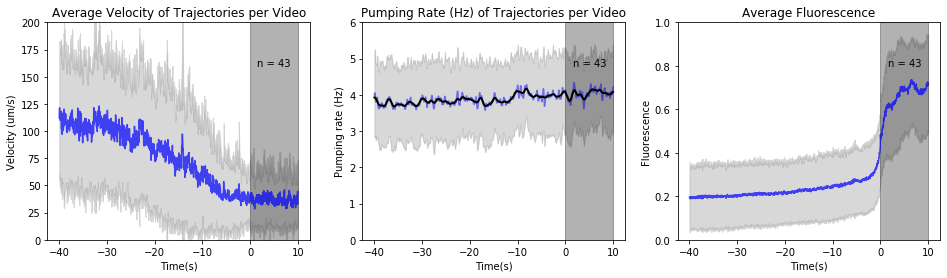

In [31]:
Data = loadPharaglow(strains, directories, index=0)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
# change plot variable and method
graphing(Data, strains[0], avgplot, method = 'average', save = 'Yes')

In [32]:
# v, pr = [], []
# for idx in Data.keys():
#     if Data[idx]['enter']:
#         # pumping rate using rolling mean rate in a rolling 1 second window
#         #tmp = pd.Series(df[idx]['binaryPumpsCut']).rolling(fps).sum()
#         tmp = Data[idx]['pumpInterpCut']
#         pr.append(tmp)
#         v.append(Data[idx]['velocityCut'])
# plt.scatter(v, pr, color = 'blue', alpha = 0.4)
# plt.ylabel('Pumping rate (Hz)')
# plt.xlabel('Velocity (um/s)')

#### Control (5hr old lawn)

In [33]:
# readPharaglow(strains, directories, index=8)

5 0.0
1021 0.6729540614542135
362 0.7048145224940805
82 0.0
0 0.9949031600407747
938 0.4989464812473662
0 1.0
0 1.0
1033 0.4140926640926641
0 1.0
0 0.7753786658072833
1123 0.41212512092873266
983 0.8149663840982169
20 0.9650032404407
784 0.8753194799422158
277 1.0
994 0.5764854614412137
90 0.3014950166112957
0 1.0
0 0.9654775604142692
17 0.0
1162 0.6524167148083959
635 0.6941724941724942
625 0.7159807193177605
5 0.0
0 0.9921158782544921
79 0.19606164383561644
670 0.6139032409581964
123 0.41682974559686886
97 0.8988269794721407
1362 0.3720316622691293
1306 0.28285857071464265
2 0.0
970 0.6605154311167675
845 0.482400461627236
1 0.8454001088731627
896 0.7658018867924529
9 0.0
56 0.9812054439403759
2 0.0
694 0.33843437316068276
7 1.0
653 0.7600918936659009
877 0.44355971896955504
3 1.0
0 0.8371970495258166
0 0.8097902097902098
1 0.9635627530364372
0 1.0
2 0.0
597 0.9273252583620403
1420 0.6210470369386129
0 0.7067729083665338
1 0.990645463049579
0 0.9640866873065016
NZ0191_results_28.json

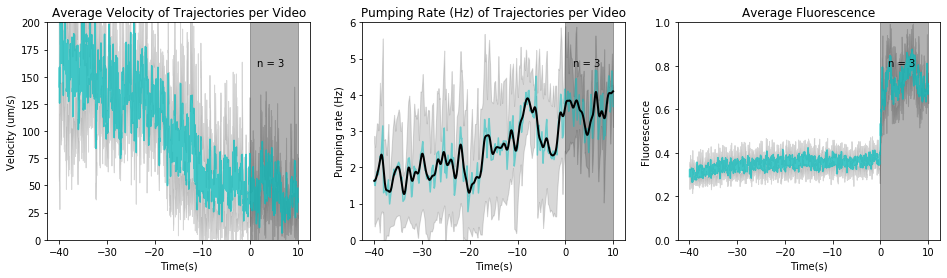

In [34]:
Data = loadPharaglow(strains, directories, index=8)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[8], avgplot, method = 'average', save = 'Yes')

#### Control (freshly seeded lawn)

In [35]:
#readPharaglow(strains, directories, index=7)

15 0.7848214285714286
734 0.8878678753259654
0 1.0
41 1.0
230 0.7242921013412816
458 0.6883435582822086
0 0.9263521288837745
0 0.18922018348623854
468 0.5874206578188114
349 0.578397212543554
0 0.9513860988348735
11 0.0
0 0.5470219435736677
311 1.0
22 0.23125996810207336
0 0.5831223628691983
0 1.0
3 0.0
333 0.4070390206579954
119 0.5981198589894242
0 0.0
1 0.3519892110586649
8 1.0
0 1.0
0 0.03628773281952473
427 0.5265751495952129
609 0.1972058033315422
1 1.0
976 0.2628443782576322
24 0.7200538358008075
1121 0.4163664436438497
0 0.054490413723511606
0 0.0
0 1.0
0 0.12997129971299712
3 1.0
411 0.8974948287749942
0 1.0
43 0.9310111141230686
1 0.0
254 0.1706896551724138
0 1.0
279 0.6088888888888889
0 0.0
0 1.0
15 1.0
765 0.6500159083678014
643 0.7949446180062483
247 1.0
7 0.9145129224652088
0 0.9476386036960985
193 0.9218802089121013
458 0.4184720638540479
15 0.0
2 0.9952670723461798
1065 0.31625736192910325
84 0.33803535010197144
133 0.916396629941672
257 1.0
664 0.8583279115159401
11 1.

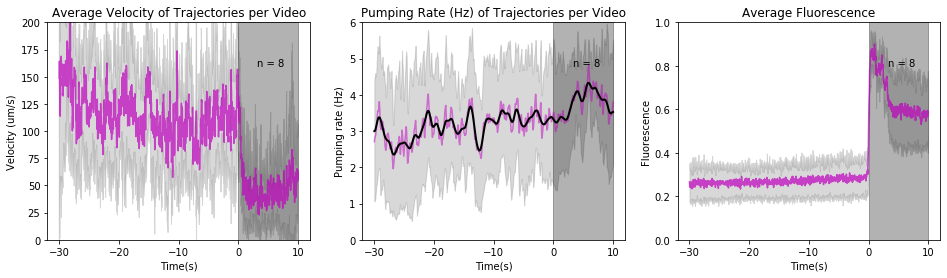

In [36]:
Data = loadPharaglow(strains, directories, index=7)
Data = alignData(Data, tBefore=30*fps, tAfter=tAfter)
graphing(Data, strains[7], avgplot, method = 'average', save = 'Yes')

#### INF100

In [37]:
#readPharaglow(strains, directories, index=1)

2442 0.7138832544512058
3040 0.33960270498732037
4352 0.16818886782698605
1350 0.6319093762795142
1364 0.5886209578842093
12 0.0
6 1.0
0 0.0
2546 0.3667213114754098
0 0.0
197 1.0
1339 0.38351581508515814
915 0.0
1114 0.76502828854314
0 0.5762910798122066
78 0.0
2396 0.5060091905266879
692 0.7946724262059035
615 0.0
1603 0.0676148286313826
13 0.0
2427 0.23067740972843928
1630 0.6717313824798349
1491 0.7526727301739269
83 0.0
13 0.0
7 0.0
1 0.0
0 0.0
1017 0.0
3676 0.04637931034482758
1791 0.6489609956661851
1 0.0
1 1.0
7 0.0
4453 0.0
53 0.0
15 0.0
5 0.0
1540 0.09161894846434149
23 0.0
0 0.0
3695 0.23023658395845356
138 0.8647686832740213
0 1.0
2585 0.2024323264025108
66 0.0
13 0.0
2758 0.3468082538916375
0 1.0
1271 0.033270950301517985
163 0.0
0 0.8971291866028708
2356 0.49413754227733936
0 1.0
63 1.0
1292 0.12222222222222222
1 0.0
2364 0.30985552115583076
1 0.0
0 0.0
18 0.0
0 0.0
1770 0.0362495643081213
0 0.7051630434782609
0 1.0
0 0.0
5 0.9792663476874003
241 0.360054347826087
1729 0.5

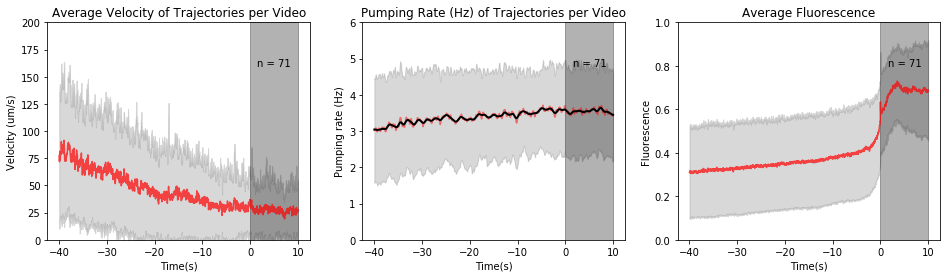

In [38]:
Data = loadPharaglow(strains, directories, index=1)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[1], avgplot, method = 'average', save = 'Yes')

#### INF101

In [39]:
#readPharaglow(strains, directories, index=6)

15 0.0
0 1.0
94 0.0
0 1.0
28 1.0
2271 0.37608806963645675
10 0.0
1367 0.0
2 0.0
3 0.0
997 0.0
2351 0.5193554361918874
1877 0.77753083675964
279 0.0
1352 0.15171473995003407
1694 0.12259615384615384
24 0.0
782 0.0
12 1.0
9 0.0
65 0.0
3785 0.5386539606908874
43 1.0
76 0.9874253379440427
5 0.0
1225 0.020221473278767454
410 0.015085484411666107
0 0.0
789 0.370485609512168
2 0.0
0 0.1899059024807528
1409 0.32637571157495254
248 0.7295597484276729
2018 0.12197547232350017
1834 0.07831165383594373
1660 0.22308598351001177
1164 0.13763563677898344
1 0.0
1860 0.0
226 0.8012942519984774
6 0.0
16 0.0
1795 0.586398488720969
0 0.0
4 0.0
2 0.0
1710 0.6485549132947976
0 0.0
0 1.0
0 1.0
2051 0.36234652114597543
1 0.0
5 0.0
1594 0.009574468085106383
467 0.0
4 0.0
294 0.0
1365 0.0
66 0.0
0 0.0
1 0.0
2710 0.2886766076421249
0 0.0
2654 0.23035892876986333
1600 0.0
6 1.0
14 0.0
20 0.0
337 0.0
1522 0.5729466858789626
2189 0.13968481375358166
0 0.9161118508655126
9 0.0
3 0.0
1 0.0
1411 0.33303597977995836
14

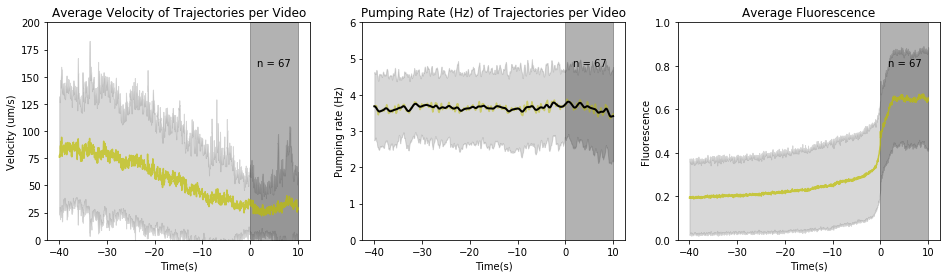

In [40]:
Data = loadPharaglow(strains, directories, index=6)
Data = alignData(Data, tBefore=40*fps, tAfter=tAfter)
graphing(Data, strains[6], avgplot, method = 'average', save = 'Yes')

#### INF102

In [41]:
#readPharaglow(strains, directories, index=2)

383 0.9811725846407927
1 0.0
6866 0.0344490328189524
3 0.0
1 0.0
0 0.0
0 0.0
2 0.0
2 0.0
1 0.0
0 0.0
3946 0.2495203990280087
3858 0.07368421052631578
744 0.49159663865546216
12 0.0
0 0.8715538847117794
1 0.0
5 0.0
3523 0.4271444426827335
1 0.0
80 0.0
571 0.0
154 0.0
0 0.0
800 0.0
16 0.0
0 0.0
7 0.0
545 0.3165137614678899
1143 0.7196927529778471
0 0.46563814866760167
0 1.0
25 0.0
2 0.0
2 0.0
2 0.0
2957 0.040811021575253445
1 0.0
4 0.0
7 0.0
3 0.0
0 0.0
0 0.0
1 0.0
0 0.0
4545 0.5398544592993738
0 0.3605143484397052
241 0.6102088167053364
5080 0.19844983913424977
1 0.0
2956 0.1554739797020082
2 0.0
1 0.0
1 0.0
3755 0.3429655339413996
2 0.0
0 0.40657276995305164
0 1.0
0 0.0
0 0.5776722090261283
1 0.6878824969400245
8 0.0
0 0.0
2 0.0
0 0.0
2 0.0
0 0.0
2 0.0
2 0.0
319 0.8116846284741918
580 0.47084708470847086
2543 0.5791746641074856
85 0.8861578266494179
0 0.41506849315068495
2952 0.2505260552048521
65 1.0
0 0.0
1 0.0
0 0.0
0 0.9577142857142857
21 0.0
5 0.0
1 0.0
0 0.0
0 0.0
12 0.0
3671 0.2

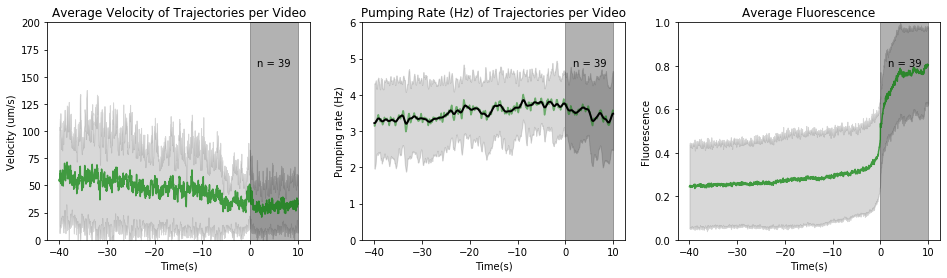

In [42]:
Data = loadPharaglow(strains, directories, index=2)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[2], avgplot, method = 'average', save = 'Yes')

#### INF103

In [43]:
#readPharaglow(strains, directories, index=3)

919 0.018821198613174838
1156 0.46584699453551914
3 1.0
2 0.0
6 0.0
571 0.025530073561228904
1166 0.13295880149812733
1009 0.17381404174573056
1779 0.26229508196721313
0 0.5192092502797464
936 0.8257667068434444
0 0.6628003314001657
0 0.0
0 1.0
1 0.9629629629629629
1921 0.3843774168600155
2473 0.5788296682817742
981 0.5432900432900433
1639 0.29614767255216695
195 0.044265887509130755
45 0.9593160377358491
3 0.0
4 1.0
0 1.0
0 1.0
762 0.5506519558676028
0 1.0
0 0.7111496244945118
4 0.0
475 0.48868778280542985
2992 0.5135009310986964
112 1.0
0 0.11301044634377967
0 0.9945474372955289
3 0.8975609756097561
422 0.0
0 0.00522875816993464
0 1.0
41 1.0
0 0.6006475984889369
1 0.0
1231 0.13070440451582127
0 0.8687350835322196
834 0.054777845404747415
0 1.0
0 0.24631956912028724
298 0.7988980716253443
831 0.13031275060144346
616 0.6906966490299824
3 0.0
1443 0.5854505971769816
1120 0.6329830234438156
1350 0.21673342234089898
0 0.23620662082200544
9 0.10916179337231968
35 1.0
1211 0.617398831421770

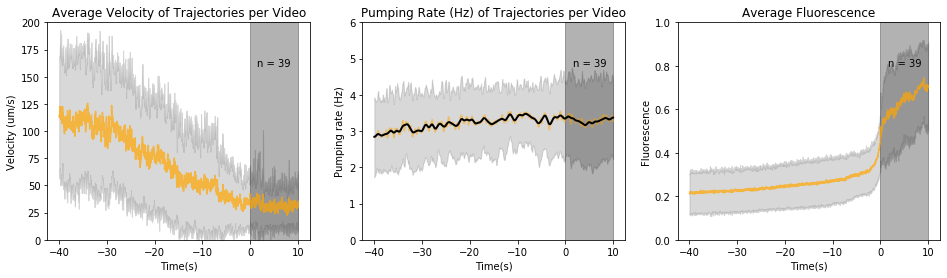

In [44]:
Data = loadPharaglow(strains, directories, index=3)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[3], avgplot, method = 'average', save = 'Yes')

#### INF4

In [45]:
#readPharaglow(strains, directories, index=5)

2275 0.27913752913752915
1274 0.3396054628224583
832 0.5208226221079691
68 0.0
3 1.0
0 1.0
1 0.0
0 0.0
76 1.0
196 0.7609561752988048
857 0.0
844 0.45288574793875147
35 0.0
0 1.0
0 0.8147668393782384
2 0.0
96 1.0
0 0.8215743440233236
0 1.0
1537 0.4367968232958306
3 0.876412429378531
116 0.8467635402906208
0 0.9461382113821138
64 0.6137538779731128
16 1.0
0 0.1517509727626459
2 0.9371002132196162
2961 0.37621324062002026
518 0.31153846153846154
735 0.6657649534114818
85 1.0
0 0.9663608562691132
694 0.8207807570977917
0 0.21621621621621623
3 1.0
0 1.0
720 0.5308102862688016
1549 0.5800752968433246
1 1.0
653 0.03915507470376095
784 0.599783471670877
9 1.0
25 0.8532374100719424
23 0.9834331337325349
1148 0.21990291262135922
0 1.0
1094 0.23867262284620294
1596 0.5244080678164279
0 0.4962089300758214
473 0.6742857142857143
0 1.0
1 0.8879484079000403
837 0.16480891719745222
835 0.7709779179810725
931 0.6191957874581139
2 0.0
0 0.32323232323232326
0 1.0
1383 0.47772119669000634
1 0.0
0 0.774119

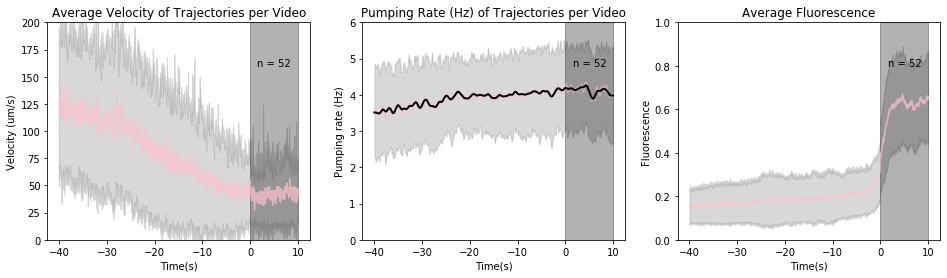

In [46]:
Data = loadPharaglow(strains, directories, index=5)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[5], avgplot, method = 'average', save = 'Yes')

#### INF5

In [47]:
#readPharaglow(strains, directories, index=4)

1 0.0
1 0.0
0 0.0
540 0.0
1159 0.0
4577 0.16193931398416886
2 0.0
137 0.007000777864207134
0 0.0
1194 0.415088230532621
3905 0.3869361894705084
10 0.0
4 0.0
154 0.0
1 0.0
0 0.0
1300 0.2823654768247203
1 0.0
590 0.0
2117 0.4358262029114346
0 1.0
0 0.0
0 0.0
1955 0.7939442390326771
0 0.0
1 0.0
0 1.0
5157 0.34892765862873654
2 0.0
0 0.0
1634 0.2743559565842814
1 0.0
2 0.0
4565 0.4370699223085461
0 0.0
5 0.0
68 0.0
2 0.0
1 0.0
92 0.0
2 0.0
5 0.0
0 1.0
18 0.0
0 0.0
1120 0.11926353393789503
0 0.0
0 0.0
27 0.0
0 0.008443908323281062
7 0.0
1037 0.5918471337579618
218 0.0
8 1.0
1 0.0
6 0.0
3 0.0
0 1.0
4 0.9842041312272175
3 0.0
2 0.0
6 0.0
1 0.0
0 0.0
9 0.0
1 0.0
4 1.0
1 1.0
1 0.0
0 0.0
1 0.0
1 0.0
2191 0.0
5 0.0
0 0.0
12 0.0
0 0.0
2 0.0
0 0.0
1514 0.3646199241253337
25 1.0
0 0.0
5 0.0
21 0.0
16 0.0
1 0.0
0 1.0
2520 0.7181809514729717
20 0.0
5 0.0
8 0.0
12 1.0
25 0.0
3765 0.6592419615591881
5 0.0
544 0.9211023447049672
2 0.10172655156322911
1 1.0
65 0.8980044345898004
4 0.0
1753 0.6291322314049

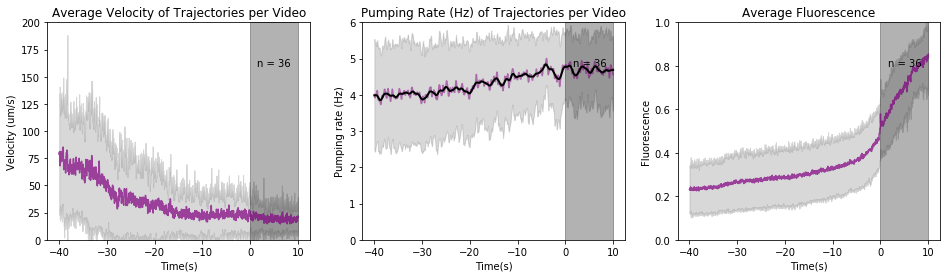

In [49]:
Data = loadPharaglow(strains, directories, index=4)
Data = alignData(Data, tBefore=tBefore, tAfter=tAfter)
graphing(Data, strains[4], avgplot, method = 'average', save = 'Yes')